# Tune the algorithms designed for non-stationary environments

In this notebook I tune the hyper parameters PS-LinUCB.
I tune parameters for Algorithm1 separately because it takes more time. 
For both algorithms I prepare the data with stationary costs and 2 change-points. This data is saved here for use in a separate tuning script for Algorithm1.


Here I use data saved in notebook 20.

In [1]:
import os
os.chdir("../../..")
os.getcwd()

'/Users/sbokupripeku/git/work/bandits/NCC-Bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

from src import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the data saved in experiment 20

In [5]:
with open('dataset/nursery/nursery_tuning.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [6]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [7]:
all_rewards.shape[0]

2630

In [8]:
stationarity_regions = [
    slice(0, 1000),
    slice(1000, 2000),
    slice(2000, all_contexts.shape[0]),
]

In [9]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [10]:
change_point_values

[1, 1000, 2000, 2630]

In [11]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.33612167, 0.00076046, 0.02357414, 0.3365019 , 0.30304183])

In [12]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [13]:
new_contexts.shape, new_rewards.shape

((2630, 5), (2630, 5))

## Plot expected reward

Min expected reward for arm 1: 0.14444444444444443
Min expected reward for arm 2: 0.002
Min expected reward for arm 3: 0.0
Min expected reward for arm 4: 0.0
Min expected reward for arm 5: 0.0


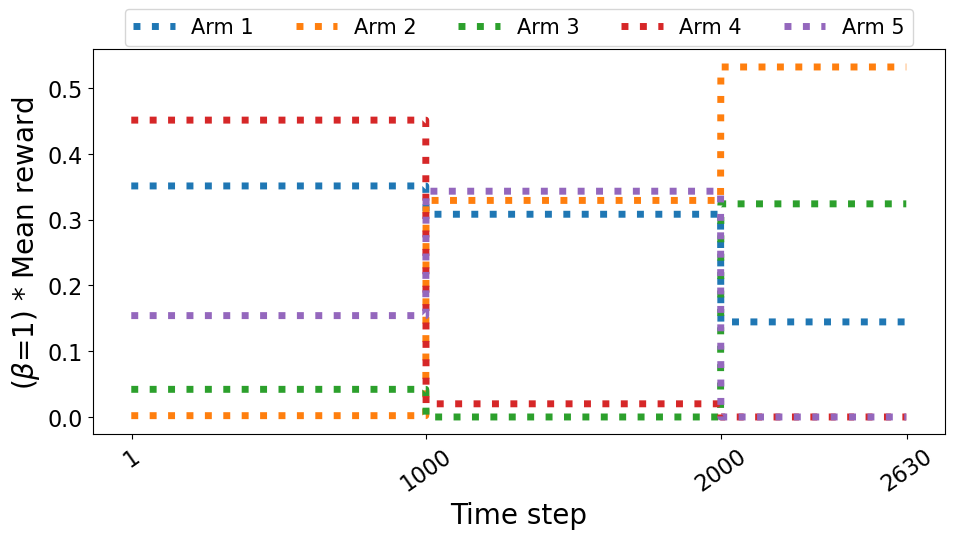

In [14]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()


### Non-stationarity in costs

In [15]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [16]:
cost_means_range = [0.05, 0.1]

In [17]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [18]:
# Mean of gaussian distribution
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [19]:
interval_means

[array([0.06872701, 0.09753572, 0.0865997 , 0.07993292, 0.05780093])]

In [20]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [21]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

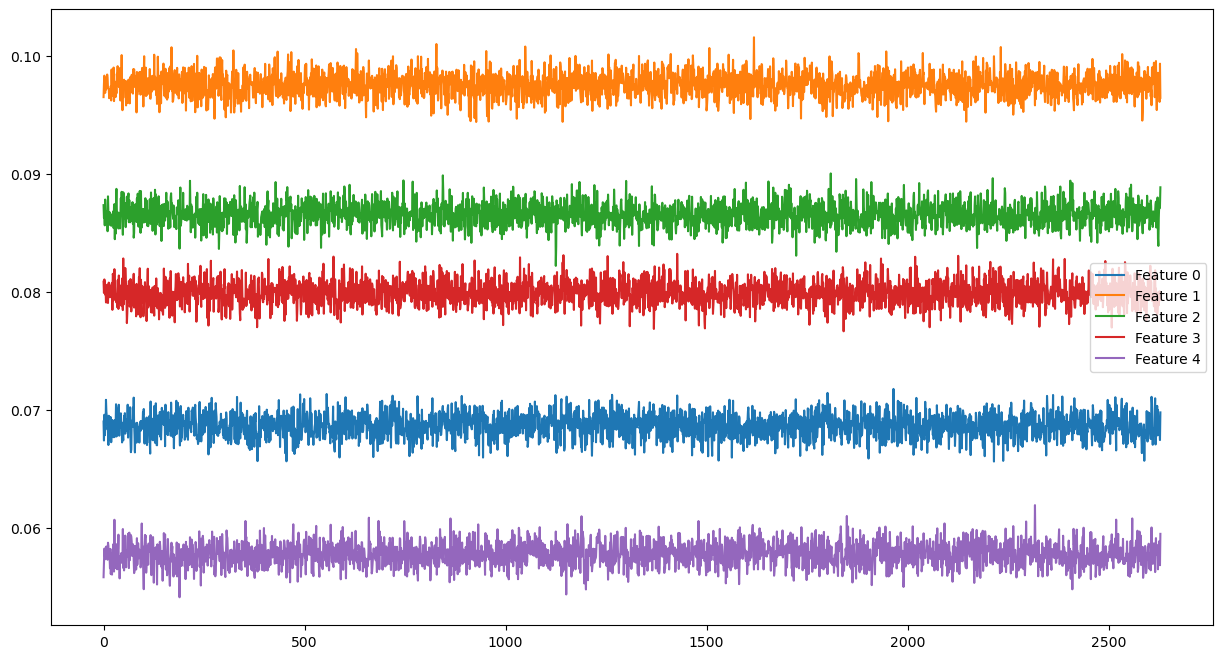

In [22]:
plot_costs(get_costs(), new_contexts.shape[0])

In [23]:
costs_obj = get_costs()

In [24]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [25]:
costs_vector.shape

(2630, 5)

## Plot expected reward minus sum of costs

In [26]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.2524237774738029
Min expected gain for arm 2: -0.3962122500476475
Min expected gain for arm 3: -0.3975310081437057
Min expected gain for arm 4: -0.39686822191824733
Min expected gain for arm 5: -0.39686822191824733


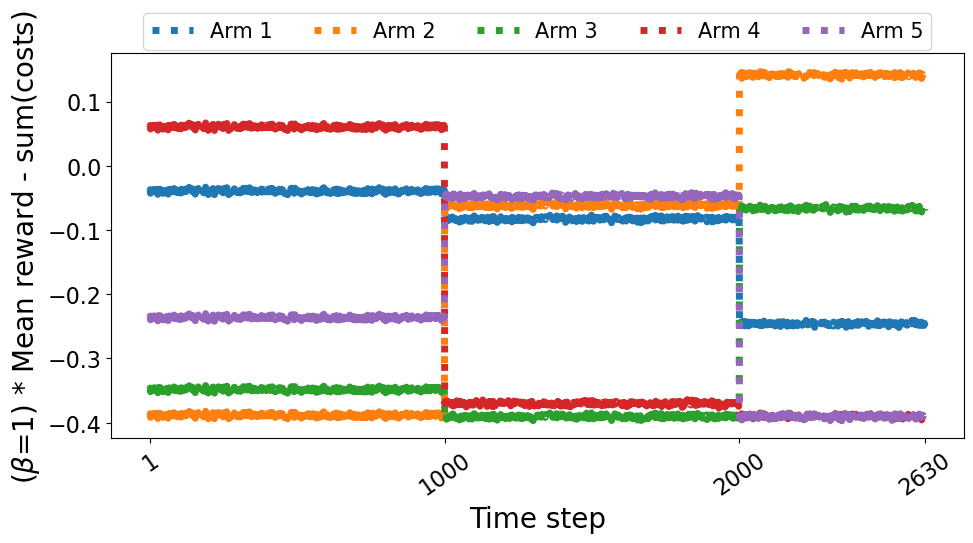

In [27]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()


In [28]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = all_change_point_values
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Save the data

In [29]:
data = (new_contexts, new_rewards, costs_vector)

In [30]:
import pickle

with open('dataset/nursery/nursery_tuning_full.pickle', 'wb') as f:
    pickle.dump(data, f)

# Tuning

In [36]:
TUNING_NUM_OF_TRIALS = all_contexts.shape[0]
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [37]:
np.random.seed(42)

## PS-LinUCB

In [32]:
ps_linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for omega in [100, 300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
            for i in range(NUM_REPETITIONS):

                ps_linucb = algorithms.PSLinUCB(
                    n_trials=TUNING_NUM_OF_TRIALS,
                    context_dimension=new_contexts.shape[1],
                    n_arms=new_rewards.shape[1],
                    alpha=alpha,
                    omega=omega,
                    delta=delta,
                )


                gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                    ps_linucb,
                    new_contexts,
                    new_rewards,
                    costs_vector,
                    beta=BETA,
                    stop_after=TUNING_NUM_OF_TRIALS,
                )
                change_points = ps_linucb.change_points
                gains[i, :] = gain_pslinucb

            gain_pslinucb = np.mean(gains, axis=0)
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, delta=0.005)
Beta = 1
Total gain: 741.9083878325727
	Total reward: 1769.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=100, 

PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 338.9083878325733
	Total reward: 1366.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=300, delta=

PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 37.90838783257391
	Total reward: 1065.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 37.90838783257391
	Total reward: 1065.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 37.90838783257391
	Total reward: 1065.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 37.90838783257391
	Total reward: 1065.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 37.90838783257391
	Total reward: 1065.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=500, delta=0.15)
Beta = 1
Total gain: 38.908387832573894
	Total reward: 1066.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=500, delta=0.15

PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1000, delta

PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta=0.03)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1250, delta

PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.1)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.1)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.1)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1500, delta=0.

PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 138.908387832574
	Total reward: 1166.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.001, omega=2000, delta=0.00

PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, delta=0.01)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, delta=0.01)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, delta=0.01)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=100, del

PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.05)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=300, delta=0

PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 38.90838783257384
	Total reward: 1066.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 38.90838783257384
	Total reward: 1066.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 38.90838783257384
	Total reward: 1066.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=500, delta=0.2)
Beta = 1
Total gain: 43.90838783257384
	Total reward: 1071.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=500, delta=0.2)
Beta = 1
Total gain: 43.90838783257384
	Total reward: 1071.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=500, delta=0.2)
Beta = 1
Total gain: 43.90838783257384
	Total reward: 1071.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=500, delta=0.2

PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1000,

PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1250, delta=0.03)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1250, delta=0.05)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1250, delta=0.05)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1250, delta

PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0.15)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0.15)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0.15)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0.15)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=1500, delta=0

PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.005, omega=2000,

PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=100, delta=0.01)
Beta = 1
Total gain: 590.9083878325729
	Total reward: 1618.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=100, delta=0.03)
Beta = 1
Total gain: 619.9083878325736
	Total reward: 1647.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=100, delta=0.03)
Beta = 1
Total gain: 619.9083878325736
	Total reward: 1647.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=100, delta=0.03)
Beta = 1
Total gain: 619.9083878325736
	Total reward: 1647.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=100, delta=0.03)
Beta = 1
Total gain: 619.9083878325736
	Total reward: 1647.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=100, delta=0.03)
B

PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.1)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.15)
Beta = 1
Total gain: 295.9083878325733
	Total reward: 1323.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=300, delta=0.15)
Beta =

PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta = 1
Total gain: 45.90838783257384
	Total reward: 1073.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=500, delta=0.2)
Beta = 1
Total gain: 45.90838783257384
	Total reward: 1073.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=750, delta=0.001)
Beta = 1
Total gain: 119.90838783257392
	Total reward: 1147.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=750, delta=0.001)
Beta = 1
Total gain: 119.90838783257392
	Total reward: 1147.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=750, delta=0.001)
Beta = 1
Total gain: 119.90838783257392
	Total reward: 1147.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=750, delta=0.001)
Beta = 1
Total gain: 119.90838783257392
	Total reward: 1147.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=750, delta=0

PSLinUCB (alpha=0.01, omega=1000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.03)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1000, delta=0.03)


PSLinUCB (alpha=0.01, omega=1250, delta=0.05)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.05)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.1)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1250, delta=0.1)
Beta 

PSLinUCB (alpha=0.01, omega=1500, delta=0.2)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1500, delta=0.2)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1500, delta=0.2)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1500, delta=0.2)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1750, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1750, delta=0.001)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=1750, delta=0.001)
B

PSLinUCB (alpha=0.01, omega=2000, delta=0.005)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.01)
Beta = 1
Total gain: 137.908387832574
	Total reward: 1165.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.01, omega=2000, delta=0.03)

PSLinUCB (alpha=0.05, omega=100, delta=0.05)
Beta = 1
Total gain: 676.9083878325736
	Total reward: 1704.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=100, delta=0.05)
Beta = 1
Total gain: 676.9083878325736
	Total reward: 1704.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=100, delta=0.05)
Beta = 1
Total gain: 676.9083878325736
	Total reward: 1704.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=100, delta=0.05)
Beta = 1
Total gain: 676.9083878325736
	Total reward: 1704.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=100, delta=0.1)
Beta = 1
Total gain: 690.9083878325733
	Total reward: 1718.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=100, delta=0.1)
Beta = 1
Total gain: 690.9083878325733
	Total reward: 1718.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=100, delta=0.1)
Beta

PSLinUCB (alpha=0.05, omega=300, delta=0.15)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=300, delta=0.2)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=300, delta=0.2)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=300, delta=0.2)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=300, delta=0.2)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=300, delta=0.2)
Beta = 1
Total gain: 339.9083878325733
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=500, delta=0.001)
Beta 

PSLinUCB (alpha=0.05, omega=750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, delta=0.01)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, delta=0.01)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=750, del

PSLinUCB (alpha=0.05, omega=1000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1000, 

PSLinUCB (alpha=0.05, omega=1250, delta=0.15)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, delta=0.15)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, delta=0.15)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, delta=0.15)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, delta=0.2)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, delta=0.2)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1250, de

PSLinUCB (alpha=0.05, omega=1750, delta=0.001)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1750, delta=0.001)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=1750, delta=0.005)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=

PSLinUCB (alpha=0.05, omega=2000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, delta=0.03)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, delta=0.05)
Beta = 1
Total gain: 129.90838783257405
	Total reward: 1157.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.05, omega=2000, 

PSLinUCB (alpha=0.1, omega=100, delta=0.1)
Beta = 1
Total gain: 606.9083878325733
	Total reward: 1634.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.1)
Beta = 1
Total gain: 606.9083878325733
	Total reward: 1634.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Beta = 1
Total gain: 645.9083878325736
	Total reward: 1673.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Beta = 1
Total gain: 645.9083878325736
	Total reward: 1673.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Beta = 1
Total gain: 645.9083878325736
	Total reward: 1673.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Beta = 1
Total gain: 645.9083878325736
	Total reward: 1673.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=100, delta=0.15)
Beta = 1
T

PSLinUCB (alpha=0.1, omega=500, delta=0.001)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.001)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.001)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.001)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.001)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.005)
Beta = 1
Total gain: 243.90838783257362
	Total reward: 1271.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=500, delta=0.

PSLinUCB (alpha=0.1, omega=750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.03)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.03)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.03)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=750, delta=0.03)
Be

PSLinUCB (alpha=0.1, omega=1000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1000, delta=0.15)


PSLinUCB (alpha=0.1, omega=1250, delta=0.2)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1250, delta=0.2)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1250, delta=0.2)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1250, delta=0.2)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1500, delta=0.001)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1500, delta=0.001)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1500, delta=0.0

PSLinUCB (alpha=0.1, omega=1750, delta=0.005)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.005)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta=0.01)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=1750, delta

PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.05)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.1)
Beta = 1
Total gain: 333.90838783257317
	Total reward: 1361.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.1, omega=2000, delta=0.

PSLinUCB (alpha=0.2, omega=100, delta=0.15)
Beta = 1
Total gain: 543.9083878325733
	Total reward: 1571.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=100, delta=0.15)
Beta = 1
Total gain: 543.9083878325733
	Total reward: 1571.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=100, delta=0.15)
Beta = 1
Total gain: 543.9083878325733
	Total reward: 1571.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=100, delta=0.2)
Beta = 1
Total gain: 687.9083878325729
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=100, delta=0.2)
Beta = 1
Total gain: 687.9083878325729
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=100, delta=0.2)
Beta = 1
Total gain: 687.9083878325729
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.2, omega=100, delta=0.2)
Beta = 1
Tot

PSLinUCB (alpha=0.2, omega=500, delta=0.001)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.005)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.005)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.005)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.005)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.005)
Beta = 1
Total gain: 209.90838783257433
	Total reward: 1237.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=500, delta=0.

PSLinUCB (alpha=0.2, omega=750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.05)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.05)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=750, delta=0.05)
Be

PSLinUCB (alpha=0.2, omega=1000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.1

PSLinUCB (alpha=0.2, omega=1500, delta=0.001)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.001)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.001)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.001)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.001)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, delta=0.005)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1500, d

PSLinUCB (alpha=0.2, omega=1750, delta=0.01)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.01)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.01)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0.03)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=1750, delta=0

PSLinUCB (alpha=0.2, omega=2000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.1)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.15)
Beta = 1
Total gain: 147.90838783257416
	Total reward: 1175.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.2, omega=2000, delta=0.15)

PSLinUCB (alpha=0.3, omega=100, delta=0.2)
Beta = 1
Total gain: 729.9083878325724
	Total reward: 1757.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=100, delta=0.2)
Beta = 1
Total gain: 729.9083878325724
	Total reward: 1757.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=300, delta=0.001)
Beta = 1
Total gain: 339.90838783257306
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=300, delta=0.001)
Beta = 1
Total gain: 339.90838783257306
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=300, delta=0.001)
Beta = 1
Total gain: 339.90838783257306
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=300, delta=0.001)
Beta = 1
Total gain: 339.90838783257306
	Total reward: 1367.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=300, delta=0.001)
B

PSLinUCB (alpha=0.3, omega=500, delta=0.01)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.01)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.01)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.01)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.01)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.03)
Beta = 1
Total gain: 226.90838783257428
	Total reward: 1254.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=500, delta=0.03)
Be

PSLinUCB (alpha=0.3, omega=750, delta=0.05)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.05)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=750, delta=0.1)
Beta = 1
Total gain

PSLinUCB (alpha=0.3, omega=1000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1250, delta=0.001)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1250, delta=0.001)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1250, delta=0.001)
Beta = 1

PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.01)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.03)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1500, delta=0.03)
Beta = 

PSLinUCB (alpha=0.3, omega=1750, delta=0.05)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.05)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.05)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.1)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=1750, delta=0.1)
Beta = 1
To

PSLinUCB (alpha=0.3, omega=2000, delta=0.15)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.3, omega=2000, delta=0.2)
Beta = 1
Total gain: 178.908387832574
	Total reward: 1206.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=100, delta=0.001)
Beta = 1
Tot

PSLinUCB (alpha=0.4, omega=300, delta=0.005)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.005)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.005)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.005)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.01)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.01)
Beta = 1
Total gain: 523.9083878325729
	Total reward: 1551.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=300, delta=0.01)
Beta

PSLinUCB (alpha=0.4, omega=500, delta=0.03)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.03)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.05)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.05)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.05)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.05)
Beta = 1
Total gain: 314.90838783257317
	Total reward: 1342.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=500, delta=0.05)
Be

PSLinUCB (alpha=0.4, omega=750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.2)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.2)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.2)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=750, delta=0.2)
Beta =

PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.005)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, delta=0.01)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1250, de

PSLinUCB (alpha=0.4, omega=1500, delta=0.03)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1500, delta=0.03)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1500, delta=0.03)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1500, delta=0.05)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1500, delta=0.05)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.4, omega=1500, delta=0.05)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1500, delta=0

PSLinUCB (alpha=0.4, omega=1750, delta=0.1)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.15)
Beta = 1
Total gain: 408.90838783257317
	Total reward: 1436.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.4, omega=1750, delta=0.

PSLinUCB (alpha=0.5, omega=100, delta=0.001)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=100, delta=0.001)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=100, delta=0.001)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.5, omega=100, delta=0.001)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=100, delta=0.005)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=100, delta=0.005)
Beta = 1
Total gain: 687.9083878325731
	Total reward: 1715.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=100, delta=0.005)
B

PSLinUCB (alpha=0.5, omega=300, delta=0.01)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.01)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.03)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.03)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.03)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.03)
Beta = 1
Total gain: 467.90838783257317
	Total reward: 1495.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=300, delta=0.03)
Be

PSLinUCB (alpha=0.5, omega=500, delta=0.1)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.1)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.1)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.15)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.15)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.15)
Beta = 1
Total gain: 248.90838783257357
	Total reward: 1276.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=500, delta=0.15)
Beta 

PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, delta=0.005)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1000, d

PSLinUCB (alpha=0.5, omega=1250, delta=0.01)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.01)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.01)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.03)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.03)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0.03)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1250, delta=0

PSLinUCB (alpha=0.5, omega=1500, delta=0.1)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.1)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.1)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.1)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.15)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.15)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1500, delta=0.15)

PSLinUCB (alpha=0.5, omega=1750, delta=0.2)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=1750, delta=0.2)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=2000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=2000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=2000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=2000, delta=0.001)
Beta = 1
Total gain: 367.90838783257317
	Total reward: 1395.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.5, omega=2000, delta

PSLinUCB (alpha=0.6, omega=100, delta=0.01)
Beta = 1
Total gain: 721.9083878325724
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.01)
Beta = 1
Total gain: 721.9083878325724
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.01)
Beta = 1
Total gain: 721.9083878325724
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.03)
Beta = 1
Total gain: 695.9083878325733
	Total reward: 1723.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.03)
Beta = 1
Total gain: 695.9083878325733
	Total reward: 1723.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.03)
Beta = 1
Total gain: 695.9083878325733
	Total reward: 1723.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=100, delta=0.03)
Beta = 1

PSLinUCB (alpha=0.6, omega=300, delta=0.1)
Beta = 1
Total gain: 513.9083878325732
	Total reward: 1541.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.1)
Beta = 1
Total gain: 513.9083878325732
	Total reward: 1541.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.1)
Beta = 1
Total gain: 513.9083878325732
	Total reward: 1541.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.1)
Beta = 1
Total gain: 513.9083878325732
	Total reward: 1541.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.1)
Beta = 1
Total gain: 513.9083878325732
	Total reward: 1541.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.15)
Beta = 1
Total gain: 506.90838783257317
	Total reward: 1534.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=300, delta=0.15)
Beta = 1
Tot

PSLinUCB (alpha=0.6, omega=500, delta=0.2)
Beta = 1
Total gain: 131.90838783257382
	Total reward: 1159.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=500, delta=0.2)
Beta = 1
Total gain: 131.90838783257382
	Total reward: 1159.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=750, delta=0.001)
Bet

PSLinUCB (alpha=0.6, omega=1000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.03)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1000, delta=0.03)
B

PSLinUCB (alpha=0.6, omega=1250, delta=0.05)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.05)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.1)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.1)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.1)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.1)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1250, delta=0.1)
Beta =

PSLinUCB (alpha=0.6, omega=1500, delta=0.2)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1500, delta=0.2)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1500, delta=0.2)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1500, delta=0.2)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1500, delta=0.2)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1750, delta=0.001)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=1750, delta=0.001)
Beta

PSLinUCB (alpha=0.6, omega=2000, delta=0.005)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.005)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.005)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.01)
Beta = 1
Total gain: 292.9083878325734
	Total reward: 1320.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.6, omega=2000, delta=0.01

PSLinUCB (alpha=0.7, omega=100, delta=0.03)
Beta = 1
Total gain: 649.9083878325733
	Total reward: 1677.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.1)
Beta = 1


PSLinUCB (alpha=0.7, omega=300, delta=0.15)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=300, delta=0.15)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=300, delta=0.15)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.15)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.2)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.2)
Beta = 1
Total gain: 518.9083878325729
	Total reward: 1546.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.2)
Beta = 1
To

PSLinUCB (alpha=0.7, omega=750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=750, delta=0.

PSLinUCB (alpha=0.7, omega=1000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0.05)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0.05)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1000, delta=0

PSLinUCB (alpha=0.7, omega=1250, delta=0.1)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.1)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.15)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.15)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.15)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.15)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1250, delta=0.1

PSLinUCB (alpha=0.7, omega=1750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, delta=0.001)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, delta=0.005)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=1750, d

PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.03)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0.05)
Beta = 1
Total gain: 346.90838783257306
	Total reward: 1374.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=2000, delta=0

PSLinUCB (alpha=0.8, omega=100, delta=0.1)
Beta = 1
Total gain: 758.9083878325727
	Total reward: 1786.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.1)
Beta = 1
Total gain: 758.9083878325727
	Total reward: 1786.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.15)
Beta = 1
Total gain: 721.9083878325727
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.15)
Beta = 1
Total gain: 721.9083878325727
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.15)
Beta = 1
Total gain: 721.9083878325727
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.15)
Beta = 1
Total gain: 721.9083878325727
	Total reward: 1749.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=100, delta=0.15)
Beta = 1
T

PSLinUCB (alpha=0.8, omega=500, delta=0.001)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.001)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.005)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.005)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.005)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.005)
Beta = 1
Total gain: 18.90838783257381
	Total reward: 1046.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=500, delta=0.005)
B

PSLinUCB (alpha=0.8, omega=750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.05)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=750, delta=0.05)
Be

PSLinUCB (alpha=0.8, omega=1000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.15)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.15)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.15)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1000, delta=0.15

PSLinUCB (alpha=0.8, omega=1500, delta=0.001)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, delta=0.001)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, delta=0.001)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, delta=0.001)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, delta=0.005)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, delta=0.005)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1500, d

PSLinUCB (alpha=0.8, omega=1750, delta=0.01)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0.01)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0.03)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=1750, delta=0

PSLinUCB (alpha=0.8, omega=2000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.1)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.15)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.15)
Beta = 1
Total gain: 236.90838783257416
	Total reward: 1264.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.8, omega=2000, delta=0.15)

PSLinUCB (alpha=0.9, omega=100, delta=0.2)
Beta = 1
Total gain: 702.9083878325733
	Total reward: 1730.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=100, delta=0.2)
Beta = 1
Total gain: 702.9083878325733
	Total reward: 1730.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=300, delta=0.001)
Beta = 1
Total gain: 529.9083878325729
	Total reward: 1557.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=300, delta=0.001)
Beta = 1
Total gain: 529.9083878325729
	Total reward: 1557.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=300, delta=0.001)
Beta = 1
Total gain: 529.9083878325729
	Total reward: 1557.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=300, delta=0.001)
Beta = 1
Total gain: 529.9083878325729
	Total reward: 1557.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=300, delta=0.001)
Beta 

PSLinUCB (alpha=0.9, omega=500, delta=0.01)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=500, delta=0.01)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=500, delta=0.01)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=500, delta=0.01)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=500, delta=0.03)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=500, delta=0.03)
Beta = 1
Total gain: 341.90838783257317
	Total reward: 1369.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=500, delta=0.03)
Be

PSLinUCB (alpha=0.9, omega=750, delta=0.05)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=750, delta=0.15)
Beta = 

PSLinUCB (alpha=0.9, omega=1000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1250, delta=0.001)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1250, delta=0.001)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1250, delta=0.0

PSLinUCB (alpha=0.9, omega=1500, delta=0.005)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=0.01)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=0.01)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=0.01)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=0.01)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=0.01)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1500, delta=

PSLinUCB (alpha=0.9, omega=1750, delta=0.05)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.05)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.05)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.05)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.1)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=1750, delta=0.1

PSLinUCB (alpha=0.9, omega=2000, delta=0.15)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=2000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=2000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=2000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=2000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.9, omega=2000, delta=0.2)
Beta = 1
Total gain: 420.90838783257317
	Total reward: 1448.0
	Total cost: 1027.0916121674268
Execution time: 0.1s


In [33]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.7, 100, 0.05)

### Evaluate tuned

In [34]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_ps_linucb,
        omega=best_omega_ps_linucb,
        delta=best_delta_ps_linucb,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 794.9083878325722
	Total reward: 1822.0
	Total cost: 1027.0916121674268
Execution time: 0.1s
Average gain: 794.9083878325722


### Algorithm1 is tuned separately

Using script3 in cloud. This is because Algorithm1 is much more computationally demanding.

## SW-UCB

In [38]:
sw_ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for tau in [100, 300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
            gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
            for i in range(NUM_REPETITIONS):

                sw_ucb = algorithms.SW_UCB(
                    n_trials=TUNING_NUM_OF_TRIALS,
                    n_arms=new_rewards.shape[1],
                    alpha=alpha,
                    tau=tau,
                )


                gain_sw_ucb = evaluation.evaluate_on_synthetic_data(
                    sw_ucb,
                    new_contexts,
                    new_rewards,
                    costs_vector,
                    beta=BETA,
                    stop_after=TUNING_NUM_OF_TRIALS,
                )
                gains[i, :] = gain_sw_ucb

            gain_sw_ucb = np.mean(gains, axis=0)
            sw_ucb_gains[(alpha, tau)] = gain_sw_ucb

SW-UCB (α=0.001, τ=100)
Beta = 1
Total gain: 988.0
	Total reward: 988.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=100)
Beta = 1
Total gain: 988.0
	Total reward: 988.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=100)
Beta = 1
Total gain: 988.0
	Total reward: 988.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=100)
Beta = 1
Total gain: 988.0
	Total reward: 988.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=100)
Beta = 1
Total gain: 988.0
	Total reward: 988.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=300)
Beta = 1
Total gain: 1021.0
	Total reward: 1021.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=300)
Beta = 1
Total gain: 1021.0
	Total reward: 1021.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=300)
Beta = 1
Total gain: 1021.0
	Total reward: 1021.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=300)
Beta = 1
Total gain: 1021.0
	Total reward: 1021.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.001, τ=3

SW-UCB (α=0.005, τ=1500)
Beta = 1
Total gain: 602.0
	Total reward: 602.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1500)
Beta = 1
Total gain: 602.0
	Total reward: 602.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1500)
Beta = 1
Total gain: 602.0
	Total reward: 602.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1750)
Beta = 1
Total gain: 740.0
	Total reward: 740.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1750)
Beta = 1
Total gain: 740.0
	Total reward: 740.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1750)
Beta = 1
Total gain: 740.0
	Total reward: 740.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1750)
Beta = 1
Total gain: 740.0
	Total reward: 740.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=1750)
Beta = 1
Total gain: 740.0
	Total reward: 740.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.005, τ=2000)
Beta = 1
Total gain: 593.0
	Total reward: 593.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.005, τ=

SW-UCB (α=0.05, τ=750)
Beta = 1
Total gain: 1101.0
	Total reward: 1101.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1000)
Beta = 1
Total gain: 902.0
	Total reward: 902.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1000)
Beta = 1
Total gain: 902.0
	Total reward: 902.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1000)
Beta = 1
Total gain: 902.0
	Total reward: 902.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1000)
Beta = 1
Total gain: 902.0
	Total reward: 902.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1000)
Beta = 1
Total gain: 902.0
	Total reward: 902.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1250)
Beta = 1
Total gain: 900.0
	Total reward: 900.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1250)
Beta = 1
Total gain: 900.0
	Total reward: 900.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1250)
Beta = 1
Total gain: 900.0
	Total reward: 900.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.05, τ=1250)
Bet

SW-UCB (α=0.2, τ=300)
Beta = 1
Total gain: 1188.0
	Total reward: 1188.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=300)
Beta = 1
Total gain: 1188.0
	Total reward: 1188.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=300)
Beta = 1
Total gain: 1188.0
	Total reward: 1188.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=300)
Beta = 1
Total gain: 1188.0
	Total reward: 1188.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=500)
Beta = 1
Total gain: 1076.0
	Total reward: 1076.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=500)
Beta = 1
Total gain: 1076.0
	Total reward: 1076.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.2, τ=500)
Beta = 1
Total gain: 1076.0
	Total reward: 1076.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=500)
Beta = 1
Total gain: 1076.0
	Total reward: 1076.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=500)
Beta = 1
Total gain: 1076.0
	Total reward: 1076.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.2, τ=750)
Beta =

SW-UCB (α=0.3, τ=1750)
Beta = 1
Total gain: 1055.0
	Total reward: 1055.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=1750)
Beta = 1
Total gain: 1055.0
	Total reward: 1055.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=1750)
Beta = 1
Total gain: 1055.0
	Total reward: 1055.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=2000)
Beta = 1
Total gain: 1123.0
	Total reward: 1123.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=2000)
Beta = 1
Total gain: 1123.0
	Total reward: 1123.0
	Total cost: 0
Execution time: 0.3s
SW-UCB (α=0.3, τ=2000)
Beta = 1
Total gain: 1123.0
	Total reward: 1123.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=2000)
Beta = 1
Total gain: 1123.0
	Total reward: 1123.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.3, τ=2000)
Beta = 1
Total gain: 1123.0
	Total reward: 1123.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.4, τ=100)
Beta = 1
Total gain: 1183.0
	Total reward: 1183.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.4, τ=100

SW-UCB (α=0.5, τ=1000)
Beta = 1
Total gain: 1268.0
	Total reward: 1268.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1250)
Beta = 1
Total gain: 1260.0
	Total reward: 1260.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1250)
Beta = 1
Total gain: 1260.0
	Total reward: 1260.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1250)
Beta = 1
Total gain: 1260.0
	Total reward: 1260.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1250)
Beta = 1
Total gain: 1260.0
	Total reward: 1260.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1250)
Beta = 1
Total gain: 1260.0
	Total reward: 1260.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1500)
Beta = 1
Total gain: 1271.0
	Total reward: 1271.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1500)
Beta = 1
Total gain: 1271.0
	Total reward: 1271.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=1500)
Beta = 1
Total gain: 1271.0
	Total reward: 1271.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.5, τ=15

SW-UCB (α=0.7, τ=500)
Beta = 1
Total gain: 1220.0
	Total reward: 1220.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=500)
Beta = 1
Total gain: 1220.0
	Total reward: 1220.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.7, τ=750)
Beta = 1
Total gain: 1162.0
	Total reward: 1162.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=750)
Beta = 1
Total gain: 1162.0
	Total reward: 1162.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=750)
Beta = 1
Total gain: 1162.0
	Total reward: 1162.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=750)
Beta = 1
Total gain: 1162.0
	Total reward: 1162.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=750)
Beta = 1
Total gain: 1162.0
	Total reward: 1162.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=1000)
Beta = 1
Total gain: 1216.0
	Total reward: 1216.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.7, τ=1000)
Beta = 1
Total gain: 1216.0
	Total reward: 1216.0
	Total cost: 0
Execution time: 0.4s
SW-UCB (α=0.7, τ=1000)
Bet

SW-UCB (α=0.8, τ=2000)
Beta = 1
Total gain: 1193.0
	Total reward: 1193.0
	Total cost: 0
Execution time: 0.2s
SW-UCB (α=0.9, τ=100)
Beta = 1
Total gain: 1281.0
	Total reward: 1281.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=100)
Beta = 1
Total gain: 1281.0
	Total reward: 1281.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=100)
Beta = 1
Total gain: 1281.0
	Total reward: 1281.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=100)
Beta = 1
Total gain: 1281.0
	Total reward: 1281.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=100)
Beta = 1
Total gain: 1281.0
	Total reward: 1281.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=300)
Beta = 1
Total gain: 1184.0
	Total reward: 1184.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=300)
Beta = 1
Total gain: 1184.0
	Total reward: 1184.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=300)
Beta = 1
Total gain: 1184.0
	Total reward: 1184.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.9, τ=300)
Beta 

In [39]:
last_gains = {k:v[-1] for k,v in sw_ucb_gains.items()}
best_alpha_sw_ucb, best_tau_sw_ucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_alpha_sw_ucb, best_tau_sw_ucb

(0.1, 100)

In [40]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    sw_ucb = algorithms.SW_UCB(
        n_trials=TUNING_NUM_OF_TRIALS,
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_sw_ucb,
        tau=best_tau_sw_ucb,
    )


    gain_sw_ucb = evaluation.evaluate_on_synthetic_data(
        sw_ucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_sw_ucb

gain_sw_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_sw_ucb[-1]}")

SW-UCB (α=0.1, τ=100)
Beta = 1
Total gain: 1302.0
	Total reward: 1302.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.1, τ=100)
Beta = 1
Total gain: 1302.0
	Total reward: 1302.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.1, τ=100)
Beta = 1
Total gain: 1302.0
	Total reward: 1302.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.1, τ=100)
Beta = 1
Total gain: 1302.0
	Total reward: 1302.0
	Total cost: 0
Execution time: 0.1s
SW-UCB (α=0.1, τ=100)
Beta = 1
Total gain: 1302.0
	Total reward: 1302.0
	Total cost: 0
Execution time: 0.1s
Average gain: 1302.0


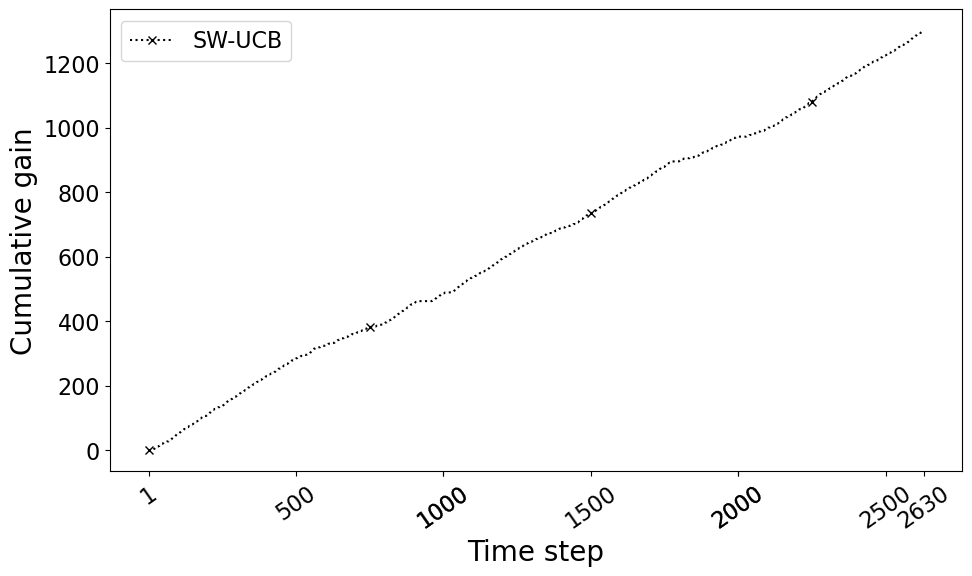

In [42]:
plot_gains({
#     'PS-LinUCB': gain_pslinucb,
    'SW-UCB': gain_sw_ucb
},
)


In [36]:
gain_pslinucb[all_contexts.shape[0]-1]

794.9083878325722